# Email Spam Classification

## Introduction and Data Exploration

In this notebook, we'll build a spam detection model to classify emails as either "ham" (legitimate) or "spam". We'll start by importing the necessary libraries and loading the dataset.

In [298]:
import re
import pickle
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf


## Load and Preprocess the Data

We'll start by loading the email dataset from a CSV file, explore the data, and perform some initial cleaning and preprocessing.

In [242]:
df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [243]:
df.shape

(5573, 2)

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [245]:
df.Category.value_counts()

Category
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64

In [246]:
df = df[df.Category != '{"mode":"full"']

<Axes: xlabel='Category'>

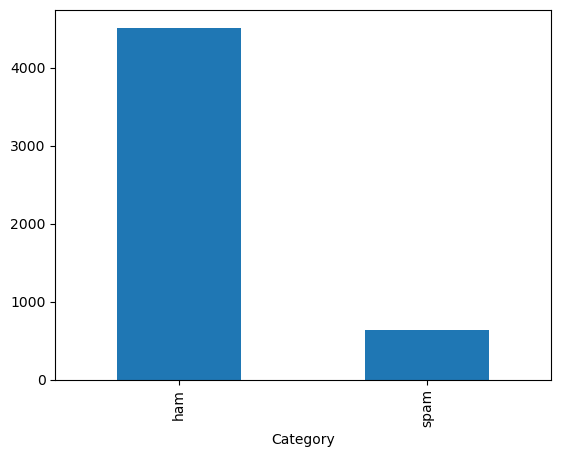

In [247]:
df.duplicated().sum() 

415

In [248]:
df = df.drop_duplicates()

In [249]:
len(df['Message'].max())

116

## Exploratory Data Analysis

Next, we'll perform some exploratory data analysis to understand the characteristics of the "ham" and "spam" emails.

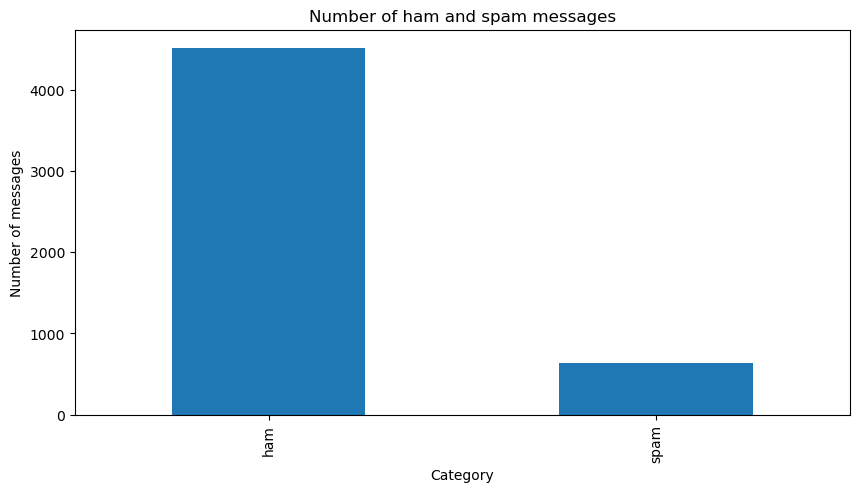

In [292]:
df.Category.value_counts().plot(kind='bar', figsize=(10, 5), title='Number of ham and spam messages', ylabel='Number of messages');

In [250]:
def is_spam(x):
    if x == 'spam':
        return 1
    else:
        return 0

In [251]:
df['spam'] = df['Category'].apply(is_spam)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


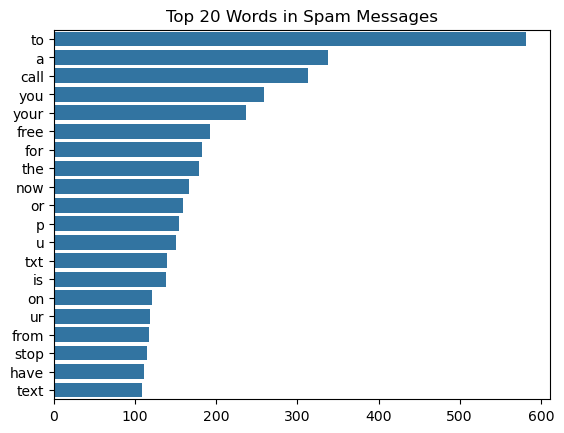

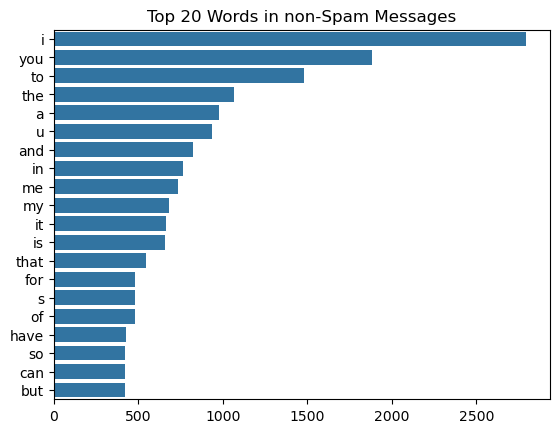

In [293]:
spam = ' '.join(df[df['spam'] == 1]['Message']).split()
non_spam = ' '.join(df[df['spam'] == 0]['Message']).split()

spam = Counter(spam).most_common(20)
non_spam = Counter(non_spam).most_common(20)

# Plotting
sns.barplot(x=[w[1] for w in spam], y=[w[0] for w in spam])
plt.title('Top 20 Words in Spam Messages')
plt.show()

sns.barplot(x=[w[1] for w in non_spam], y=[w[0] for w in non_spam])
plt.title('Top 20 Words in non-Spam Messages')
plt.show()

## Wordcloud Visualization

To further visualize the differences between "ham" and "spam" emails, we'll create word clouds for each category.

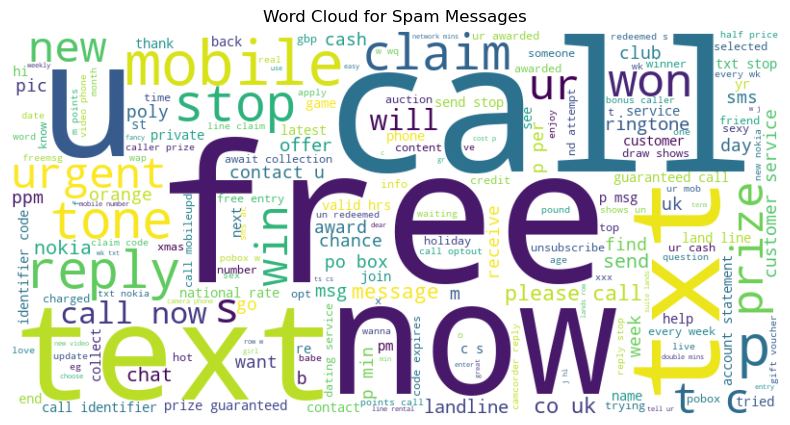

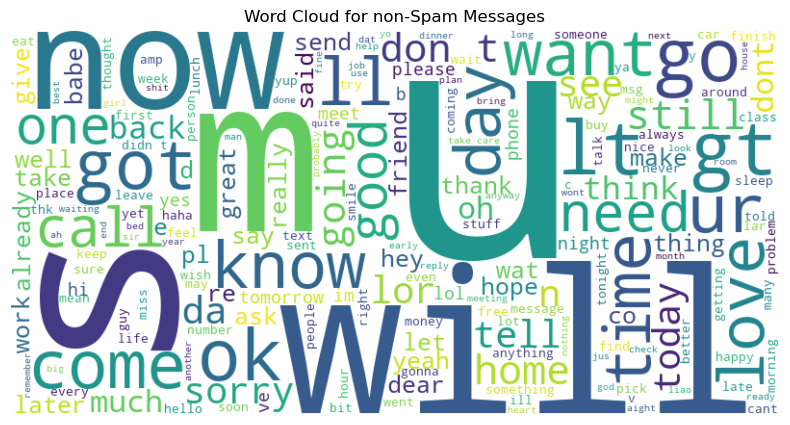

In [294]:
spam = ' '.join(df[df['spam'] == 1]['Message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

non_spam = ' '.join(df[df['spam'] == 0]['Message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_spam)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for non-Spam Messages')
plt.show()

## Text Cleaning and Feature Extraction

Before training our models, we need to clean the text data and convert it into a format that can be used for machine learning.

In [254]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [255]:
df['Message'] = df['Message'].apply(clean_text)

## Train-Test Split and Naive Bayes Model

Now, we'll split the data into training and testing sets, and train a Naive Bayes classifier to detect spam emails.

In [256]:
X = df['Message']
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [257]:
cv = CountVectorizer()
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

In [258]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [259]:
y_pred = clf.predict(X_test)

In [260]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       896
           1       0.95      0.96      0.95       136

    accuracy                           0.99      1032
   macro avg       0.97      0.97      0.97      1032
weighted avg       0.99      0.99      0.99      1032



In [261]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm

array([[889,   7],
       [  6, 130]])

<Figure size 800x600 with 0 Axes>

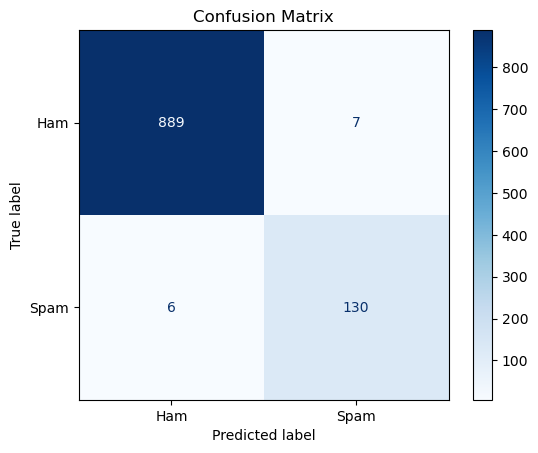

In [262]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# with open ('naive_bayes_spam_classifier.pkl', 'wb')as f:
#     pickle.dump(clf, f)

## Custom Spam Detection Function

We'll create a custom function to detect spam emails using the trained Naive Bayes model.

In [110]:
def is_spam(text):
    sequence = cv.transform([text])
    prediction = clf.predict(sequence)
    return prediction

In [111]:
test_emails = ["Congratulations! You've won a free iPhone! Click the link to claim your prize: [link]", 
               "Hey! Are we still meeting for dinner tonight? Let me know what time works for you.", 
               "You’re pre-approved for a $10,000 loan! No credit check required. Apply now to get cash fast."]

for i in range(len(test_emails)):
    spam_probability = is_spam(test_emails[i])
    is_spam_flag = (spam_probability > 0.5).astype(int)
    print(f"Email {i+1}: Spam Probability = {spam_probability}, Classified as Spam: {is_spam_flag}")

Email 1: Spam Probability = [1], Classified as Spam: [1]
Email 2: Spam Probability = [0], Classified as Spam: [0]
Email 3: Spam Probability = [1], Classified as Spam: [1]


## Preprocessing and LSTM Model

Next, we'll preprocess the data for a more advanced LSTM (Long Short-Term Memory) model and split the data into training, validation, and testing sets.

In [263]:
def preprocessing(data, max_words=10000, max_len=120, tokenizer=None):
    data['Message'] = data['Message'].apply(clean_text)
    
    if tokenizer is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_words,
            oov_token='<OOV>'
        )
        tokenizer.fit_on_texts(data['Message'])
    
    sequences = tokenizer.texts_to_sequences(data['Message'])
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences,
        maxlen=max_len,
        padding='post',
        truncating='post'
    )
    
    return padded, data['spam'], tokenizer

In [264]:
X, y, tokenizer = preprocessing(df)

In [265]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [266]:
baseline = pd.Series(y_test).value_counts(normalize=True).max()
baseline

0.8682170542635659

In [267]:
pd.Series(y_train).value_counts()

spam
0    3620
1     505
Name: count, dtype: int64

## LSTM Model Definition and Training

Now, we'll define the LSTM model architecture and train it on the preprocessed data.

In [274]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 128),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [275]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [276]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
)

In [277]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.8805 - loss: 4.6669 - val_accuracy: 0.9787 - val_loss: 0.9743
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9814 - loss: 0.6455 - val_accuracy: 0.9845 - val_loss: 0.1652
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9940 - loss: 0.1098 - val_accuracy: 0.9826 - val_loss: 0.0869
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9959 - loss: 0.0587 - val_accuracy: 0.9864 - val_loss: 0.0841
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9963 - loss: 0.0451 - val_accuracy: 0.9884 - val_loss: 0.0734
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9985 - loss: 0.0331 - val_accuracy: 0.9864 - val_loss: 0.0733
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9987 - loss: 0.0313 - val_accuracy: 0.9806 - val_loss: 0.0887
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9998 - loss: 0.0208 - val_acc

## Evaluate the LSTM Model

After training the LSTM model, we'll evaluate its performance on the test set and visualize the training and validation metrics.

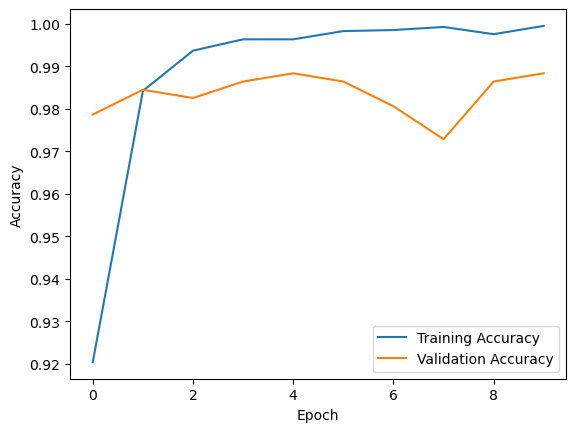

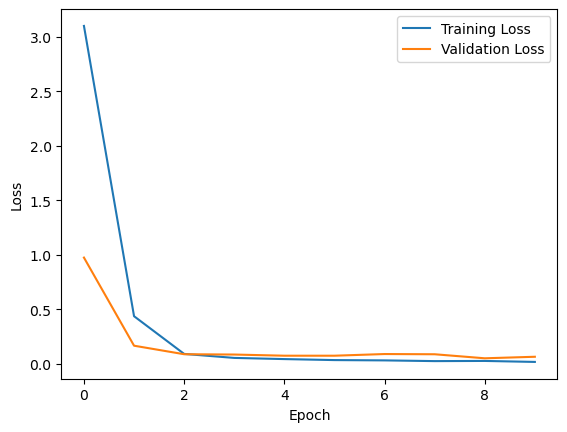

In [295]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [278]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9918 - loss: 0.0482
Test Loss: 0.04907926917076111
Test Accuracy: 0.9922480583190918


In [282]:
y_pred = model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [285]:
y_pred = (y_pred > 0.5).astype(int)

In [286]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       0.97      0.97      0.97        68

    accuracy                           0.99       516
   macro avg       0.98      0.98      0.98       516
weighted avg       0.99      0.99      0.99       516



In [287]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm

array([[446,   2],
       [  2,  66]])

<Figure size 800x600 with 0 Axes>

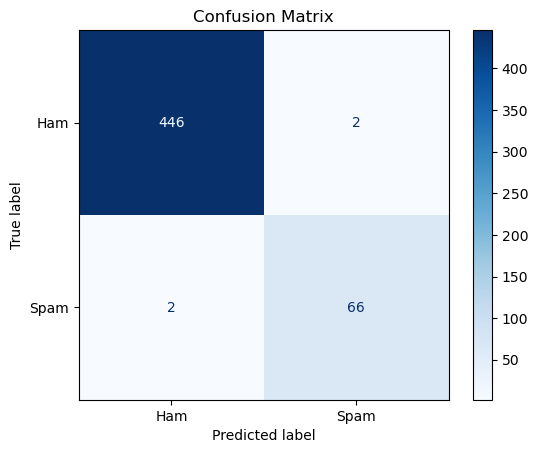

In [288]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## Test the LSTM Model

Finally, we'll use the trained LSTM model to classify some sample emails as either "ham" or "spam".

In [297]:
def is_spam(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=200, padding='post')
    prediction = model.predict(padded)
    return prediction

In [296]:
test_emails = ["Congratulations! You've won a free iPhone! Click the link to claim your prize: [link]", 
               "Hey! Are we still meeting for dinner tonight? Let me know what time works for you.", 
               "You’re pre-approved for a $10,000 loan! No credit check required. Apply now to get cash fast."]

for i in range(len(test_emails)):
    spam_probability = is_spam(test_emails[i])
    is_spam_flag = (spam_probability > 0.5).astype(int)
    print(f"Email {i+1}: Spam Probability = {spam_probability}, Classified as Spam: {is_spam_flag}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Email 1: Spam Probability = [[0.9898913]], Classified as Spam: [[1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Email 2: Spam Probability = [[0.00128233]], Classified as Spam: [[0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Email 3: Spam Probability = [[0.98920304]], Classified as Spam: [[1]]


In [ ]:
# with open ('lstm_spam_classifier.pkl', 'wb')as f:
#     pickle.dump(model, f)